In [2]:
import pandas as pd
import csv
import requests
import bs4
import codecs
import time
import re
from sklearn.utils import shuffle
from collections import defaultdict
import operator
import nltk.corpus
import random
import pickle
import numpy as np
import os

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score

In [7]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(sys.version)

In [ ]:
#import nltk
#nltk.download()

In [4]:
pd.set_option('display.max_colwidth', -1)

In [4]:
f = lambda f_name: os.path.realpath(os.path.join(os.getcwd(), f_name)).replace('\\', '/')

#### get list of test reviews

In [70]:
test_txt = ""
f = codecs.open(f("test.csv"), "r", "utf-8")
test_txt = f.read()
parser = bs4.BeautifulSoup(test_txt,'lxml')
test_list = []
test_reviews = parser.findAll('review')
for rev in test_reviews:
    test_list.append(rev.text)

In [8]:
print(test_list[4])

In [9]:
print(len(test_list))

#### gather all initial page urls from rozetka market site with reviews on mobile phones and write them into files

In [ ]:
url_list = []
start_url = ["https://rozetka.com.ua/mobile-phones/c80003/page="+str(i)+";sort=cheap/" for i in xrange(1, 16)]
#start_url = ["https://rozetka.com.ua/tablets/c130309/filter/page="+str(i)+";sort=cheap/" for i in xrange(1, 8)]

In [3]:
for url in start_url:
    text = requests.get(url).text
    parser = bs4.BeautifulSoup(text, 'lxml')
    x = parser.find_all('a', class_="novisited g-rating-reviews-link", href=True)
    for i in range(len(x)):
        url_list.append(x[i].attrs['href']) 
    time.sleep(3)    

In [10]:
print(url_list)

In [26]:
with open(f("rozetka_comments_1.txt"), 'w') as rf:
    rf.write(" ".join(url_list))

In [13]:
url_list = []
with open(f("rozetka_comments_1.txt"), 'r') as rf:
    url_list = rf.read().splitlines()

In [11]:
print(len(url_list))

#### training on single page

In [76]:
t = requests.get("https://rozetka.com.ua/globex_mint_red/p6956558/comments/")
t.encoding = 'UTF-8'
parser = bs4.BeautifulSoup(t.text, 'lxml', from_encoding=r.encoding)
review = parser.find_all('div', attrs={'class':'pp-review-inner'})
print(review)

In [77]:
num_of_pages = parser.find_all('ul', class_ ="clearfix inline")
print type(num_of_pages)
li = re.findall(r'\d+', num_of_pages[0].find_all('li')[-1].attrs['id'])[0]
print(li)

In [78]:
rev_tex = []
rev_scor = []
for i in xrange(len(review)):
    if review[i].find_all('div', attrs={'class':'g-rating-b'}):
        rev_text = " ".join([txt.text.encode('utf8') for txt in review[i].find_all('div', attrs={'class':'pp-review-text-i'})])
        rev_score = (review[i].find_all('span', attrs={'class':'sprite g-rating-stars-i'}))[0].attrs['content']
        rev_tex.append(rev_text)
        rev_scor.append(rev_score)        

In [79]:
print(rev_scor) 
print(rev_tex[5])

#### gathering reviews and ratings in the form of stars from one (very bad) to five (very good) from the web pages. If a review does not have a rating for it, such a feedback is omitted.

In [5]:
def crawler(parser, review_text, rev_score):
    review = parser.find_all('div', attrs={'class':'pp-review-inner'})
    for i in xrange(len(review)):
        if review[i].find_all('div', attrs={'class':'g-rating-b'}):
            review_text.append(" ".join([txt.text.encode('utf8') 
                                         for txt in review[i].find_all('div', attrs={'class':'pp-review-text-i'})]))
            rev_score.append((review[i].find_all('span', attrs={'class':'sprite g-rating-stars-i'}))[0].attrs['content'])   

In [6]:
def prc(url):
    t = requests.get(url)
    t.encoding = 'UTF-8'
    return bs4.BeautifulSoup(t.text, 'lxml', from_encoding=t.encoding)

In [266]:
review_text = []
review_score = []

#### for certain reasons I parse rozetka site in few consecutive steps

In [12]:
for url in url_list[329:]:
    try:    
        parser = prc(url)
        print(url)
        crawler(parser, review_text, review_score)
        time.sleep(2)
        #find number of review pages
        np = parser.find_all('ul', class_ ="clearfix inline")

        if np:
            num_of_pages = re.findall(r'\d+', np[0].find_all('li')[-1].attrs['id'])[0]

            for page in xrange(2, int(num_of_pages)+1):
                next_url = url + "page=" + str(page) + "/"
                #print(next_url)
                try:    
                    parser = prc(next_url)
                    crawler(parser, review_text, review_score) 
                    time.sleep(2)
                except (httplib.HTTPException, httplib.IncompleteRead):
                    continue    
                    
    except (httplib.HTTPException, httplib.IncompleteRead):
        continue

In [13]:
print(len(review_score))
print(len(review_text))

In [14]:
print(review_score[-1])
print(review_text[-1])

#### construct dataframe from collected reviews and write it into the file

In [271]:
scored_reviews = pd.DataFrame( {'review_text': review_text})

In [272]:
scored_reviews["label"] = review_score

In [15]:
scored_reviews.iloc[0:3]

#### at each of parse steps reviews were saved into files

In [274]:
scored_reviews.to_csv(f("seven_probe_reviews_329_end.csv"), sep='\t', encoding='utf-8')

#### then the information from all the files was concatenated in one dataframe and saved into file full.csv that is presented in project folder

In [35]:
#first = pd.read_csv(open(f("first_probe_reviews.csv")), header = 0, sep="\t")
#second = pd.read_csv(open(f("second_probe_reviews_2_29.csv")), header = 0, sep="\t")
# ...
#full = pd.concat([first, second, ... ])
#full.to_csv()

In [15]:
#full = pd.read_csv(open("full.csv"), header = 0, sep="\t")
full = pd.read_csv(f("full.csv"), header = 0, sep="\t")

In [10]:
print(full.shape)

(18850, 4)


In [16]:
full[0:2]

In [18]:
negative_1 = full.loc[full["label"] == 1]
negative_2 = full.loc[full["label"] == 2]
positive = full.loc[full["label"] == 5]
print(negative_1.shape)
print(negative_2.shape)
print(positive.shape)

#### it's clear that "excellent" reviews (marked with five stars) are much more than "awfully" reviews (marked with one stars)

#### sort reviews by length

In [17]:
index_ = defaultdict(dict)
index_ = {index: len(positive["review_text"].iloc[index]) for index in range(positive.shape[0])}
index_sorted = sorted(index_.items(), key=operator.itemgetter(1), reverse=True)
largest_indices = [int(i[0]) for i in index_sorted]

In [19]:
print largest_indices[0:2]

#### create train review data

#### make binary review rating from initial five-level score. One and two stars will be counted as negative reviews; five stars - as positive - get binary classification ploblem.  But there are much more "good" reviews than the "bad" one. Фttempt to select part of positive reviews according to a particular rule (for example choose most long or most brief of them) gives poor result. 

In [398]:
''' choose long reviews '''
#train = shuffle(pd.concat([negative_1, 
#                            negative_2, 
#                            positive[:negative_1.shape[0] + negative_2.shape[0]]]), 
#                            random_state=1).replace([1, 2], 0).replace([5], 1)
''' choose short reviews '''
#train = shuffle(pd.concat([negative_1, 
#                           negative_2, 
#                           positive.iloc[ largest_indices[-(negative_1.shape[0] + negative_2.shape[0])-7000:-7000] ]]), 
#                           random_state=1).replace([1, 2], 0).replace([5], 1)

In [24]:
train = shuffle(pd.concat([negative_1, 
                           negative_2, 
                           shuffle(positive, random_state=153)[:negative_1.shape[0] + negative_2.shape[0]]]), 
                           random_state=1).replace([1, 2], 0).replace([5], 1)

In [20]:
print(train.iloc[0, 1])

In [25]:
train_text = train['review_text']
train_label = train['label']

#### train classifier that showed best result in week_3 - LinearSVC. Select best parameters for this classifier than select best parameters for  "vectorizer" and  "transformer".

In [18]:
stop_words =  nltk.corpus.stopwords.words('russian')

In [19]:
parameters_grid_vectorizer = {
    'vectorizer__max_df' : [0.85, 0.9, 0.95, 1.0],
    'vectorizer__min_df' : [1, 10, 20], 
    'vectorizer__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)],
    'vectorizer__stop_words' : [stop_words, None],
 }

In [20]:
parameters_grid_transformer = {
    'transformer__norm' : ["l1", "l2"],
    'transformer__smooth_idf' : [True, False], 
    'transformer__use_idf' : [True, False],
    'transformer__sublinear_tf' : [True, False],
 }

In [21]:
parameters_grid_lsvc = {
    'classifier__loss' : ["hinge", "squared_hinge"], 
    'classifier__max_iter' : [400, 500, 600, 800, 1000],
    'classifier__tol' : [1e-5, 1e-4, 1e-3], 
    'classifier__C' : [0.9, 1.0, 1.1, 1.2], 
}

In [22]:
def text_classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

In [23]:
def estimator(classifier, parameters_grid, scorer, data, labels, vectorizer=CountVectorizer(), transformer=TfidfTransformer()):
    pipeline = text_classifier(vectorizer, transformer, classifier)
    
    grid_cv = GridSearchCV(pipeline, parameters_grid, scoring = scorer, cv = 4, n_jobs=-1)
    grid_cv.fit(data, labels)
    
    return grid_cv

In [71]:
%%time
LSVC_grid_search_1 = estimator(LinearSVC(random_state=1), parameters_grid_lsvc, 'accuracy', train_text, train_label)

Wall time: 1min 8s


In [21]:
print("LinearSVC accuracy: ")
#print LSVC_grid_search.grid_scores_
print(LSVC_grid_search_1.best_score_)
print(LSVC_grid_search_1.best_params_)

LinearSVC accuracy
0.907608695652
{'classifier__max_iter': 400, 'classifier__loss': 'hinge', 'classifier__C': 1.0, 'classifier__tol': 1e-05}

In [82]:
%%time
LSVC_grid_search_2 = estimator(LinearSVC(max_iter=400, loss='hinge', C= 1.0, tol=1e-05, random_state=1), 
                                         parameters_grid_vectorizer, 'accuracy', train_text, train_label)

Wall time: 9min 6s


In [22]:
print(LSVC_grid_search_2.best_score_)
print(LSVC_grid_search_2.best_params_)

0.915081521739
{'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__max_df': 0.85, 'vectorizer__stop_words': None}

In [87]:
%%time
LSVC_grid_search_3 = estimator(LinearSVC(max_iter=400, loss='hinge', C= 1.0, tol=1e-05, random_state=1), 
                               parameters_grid_transformer, 'accuracy', train_text, train_label, 
                               vectorizer=CountVectorizer(min_df = 1, ngram_range = (1, 2), max_df = 0.85)
                              )

Wall time: 29.7 s


In [23]:
print(LSVC_grid_search_3.best_score_)
print(LSVC_grid_search_3.best_params_)

0.921195652174
{'transformer__norm': 'l2', 'transformer__smooth_idf': True, 'transformer__use_idf': True, 'transformer__sublinear_tf': True}

#### try to randomly search subset of positive reviews with size equal to size of negative reviews that would show best classification result: for 50 times create subset positive reviews dataset and choose that one that shows best accuracy 

In [36]:
random_indicies = []
for i in range(50):
    random_indicies.append(random.sample(range(0, 11814), negative_1.shape[0] + negative_2.shape[0]))

In [37]:
def parameters_searcher(random_indicies_lst):
    best_score, best_params, best_ind_set = 0, {}, []
    for ind in random_indicies_lst:
        train = shuffle(pd.concat([negative_1, negative_2, positive.iloc[ind]]), 
                                   random_state=1).replace([1, 2], 0).replace([5], 1)
        train_text = train['review_text']
        train_label = train['label']
        
        LSVC_grid_search = estimator(LinearSVC(random_state=1), parameters_grid_lsvc, 'accuracy', train_text, train_label)
        if LSVC_grid_search.best_score_ > best_score:
            best_score = LSVC_grid_search.best_score_
            best_params = LSVC_grid_search.best_params_
            best_ind_set = ind
    return best_score, best_params, best_ind_set

In [38]:
%%time
best_score, best_params, best_ind_set = parameters_searcher(random_indicies)

Wall time: 53min 31s


In [24]:
best_score

In [25]:
best_params

best_score: 0.8847736625514403; best_params: {'classifier__C': 0.9, 'classifier__loss': 'hinge', 'classifier__max_iter': 400, 'classifier__tol': 1e-05}

In [4]:
with open(f('positive_rev_idx.txt'), 'wb') as f:
    pickle.dump(best_ind_set, f)

In [5]:
with open(f('positive_rev_idx.txt'), "rb") as fp:   # Unpickling
    best_ind_set = pickle.load(fp)

In [46]:
train_1 = shuffle(pd.concat([negative_1, 
                            negative_2, 
                            positive.iloc[best_ind_set]]), 
                            random_state=1).replace([1, 2], 0).replace([5], 1)

train_text_1 = train_1['review_text']
train_label_1 = train_1['label']

In [26]:
positive.iloc[best_ind_set].shape

In [47]:
%%time
LSVC_grid_search_4 = estimator(LinearSVC(max_iter=400, loss='hinge', C= 0.9, tol=1e-05, random_state=1), 
                               parameters_grid_vectorizer, 'accuracy', train_text_1, train_label_1)

Wall time: 6min 6s


In [27]:
print(LSVC_grid_search_4.best_score_)
print(LSVC_grid_search_4.best_params_)

0.8868312757201646
{'vectorizer__max_df': 0.85, 'vectorizer__min_df': 1, 'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2)}

In [49]:
%%time
LSVC_grid_search_5 = estimator(LinearSVC(max_iter=400, loss='hinge', C= 0.9, tol=1e-05, random_state=1), 
                               parameters_grid_transformer, 'accuracy', train_text_1, train_label_1, 
                               vectorizer=CountVectorizer(min_df = 1, ngram_range = (1, 2), max_df = 0.85)
                              )

Wall time: 26.2 s


In [28]:
print(LSVC_grid_search_5.best_score_)
print(LSVC_grid_search_5.best_params_)

0.8878600823045267
{'transformer__use_idf': True, 'transformer__sublinear_tf': True, 'transformer__smooth_idf': False, 'transformer__norm': 'l2'}

#### unfortunally new result does not exceed the previous result

#### make classifier with selected parameters, fit it with train data and make the prediction

In [29]:
Lin_SVC = text_classifier(vectorizer=CountVectorizer(min_df=1, ngram_range=(1, 2), max_df=0.85, stop_words=None), 
                transformer=TfidfTransformer(norm = 'l2', smooth_idf = True, use_idf = True, sublinear_tf = True), 
                classifier=LinearSVC(max_iter=400, loss='hinge', C= 1.0, tol=1e-05, random_state=1))

Lin_SVC.fit(train_text, train_label)
print Lin_SVC

In [31]:
lin_svc_result = Lin_SVC.predict(test_list)

#### manually done test dataset markup 

#### 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0? 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0? 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1? 1 0 0 0 0 1 0 ?0? 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0

#### Best classifier and best result
#### Lin_SVC = text_classifier(vectorizer=CountVectorizer(min_df=1, ngram_range=(1, 2), max_df=0.85, stop_words=None), transformer=TfidfTransformer(norm = 'l2', smooth_idf = True, use_idf = True, sublinear_tf = True), classifier=LinearSVC(max_iter=400, loss='hinge', C= 1.0, tol=1e-05, random_state=1))
#### fitted on balanced train dataset from approximately 1500 reviews on mobile phones from site https://rozetka.com.ua and written into file partial.csv; selection of reviews from the beginning

#### accuracy score 0.92

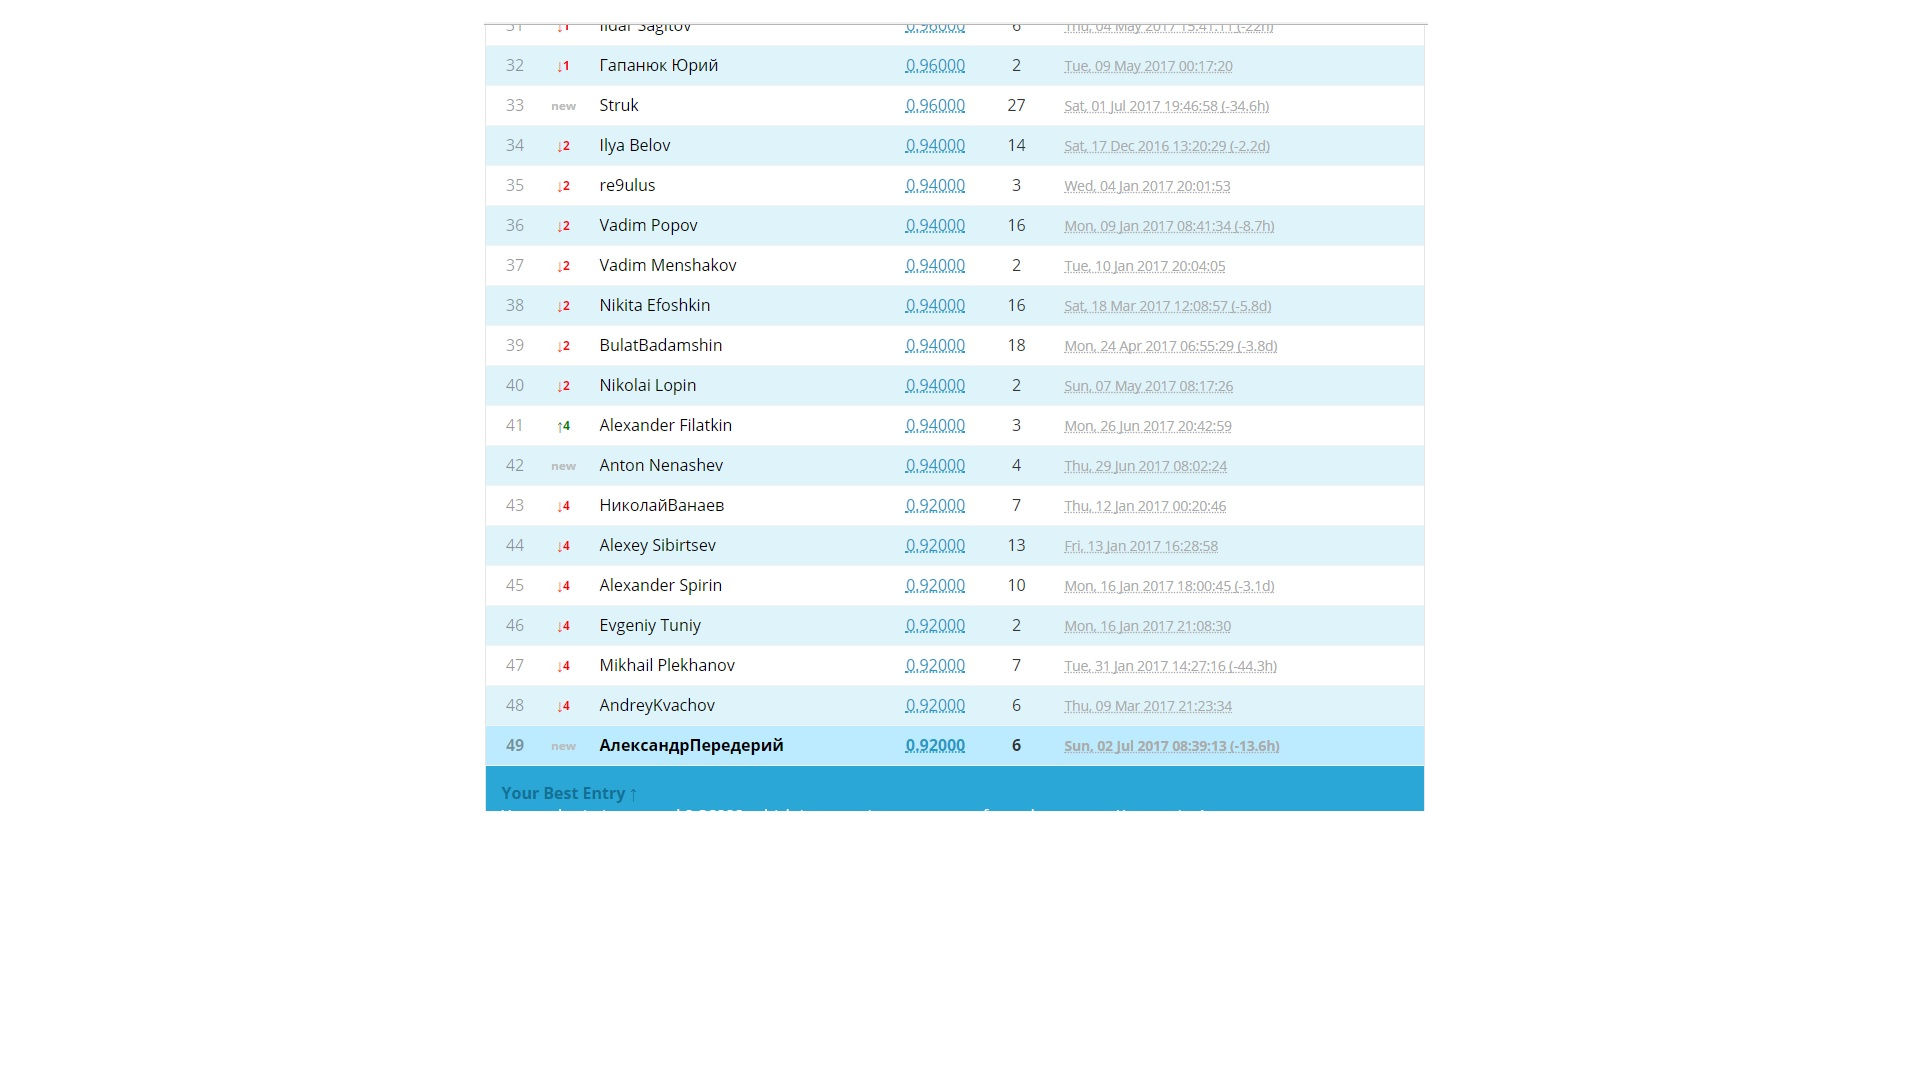

In [43]:
from IPython.display import Image
Image(f("week_6_result.jpg"))

In [248]:
print(lin_svc_result)

[0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1
 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0]


In [30]:
print type(lin_svc_result)

In [33]:
my_res = []
for i in lin_svc_result:
    if i == 0:
        my_res.append("neg")
    else:
        my_res.append("pos")

In [34]:
with open(f("week_6_answer.csv"), 'w') as f_out:
        f_out.write(pd.DataFrame(pd.Series(map(str, range(0, 100))).str.cat(map(str, my_res), sep=','), 
                                 columns = ["Id,y"]).to_csv(sep=" ", index=False))

#pd.DataFrame(lin_svc_result).to_csv()

In [264]:
my_res =  pd.read_csv(f("week_6_answer.csv"), header = 0, sep="\t")
#my_res

In [252]:
sample =  pd.read_csv("sample_submission.csv", header = 0, sep="\t")
#sample